In [237]:
import matplotlib.pyplot as plt
from scipy import spatial
import numpy as np

%reload_ext autoreload
%autoreload 2

import analysistools
from importlib import reload
reload(analysistools)

from time import sleep, perf_counter

In [238]:
snap=analysistools.SnapshotTools('../data/snap_0031','HDF5',convention='SWIFT',positions_only=False)
halo=analysistools.HaloTools('../data/halos/snap_0031.VELOCIraptor','VELOCIraptor')
tree=analysistools.TreeTools('../data/VELOCIraptor.walkabletree.forestIDs.hdf5','TreeFrog')

Assuming positions are type float32
Assuming particle IDs are type 32 bit


In [239]:
snap.ReadSnapshot()
halo.ReadHaloCatalogue()
tree.ReadMergerTreeCatalogue()

Reading data from ../data/snap_0031.hdf5
Simulation scale factor: 1.000000
Number of particles: 0000262144
Number of particle types: 7
istart: [0 0 0 0 0 0 0]
262144 1 0 262144 262144
Reading data for 522 groups
SO_Mass_200.000000_rhocrit not found in file. Skipping...
SO_R_200.000000_rhocrit not found in file. Skipping...
Reading data for 522 groups
Reading data for 56330 particles in groups
Reading data for 1126 particles in groups
Found data for 032 snapshots in file...


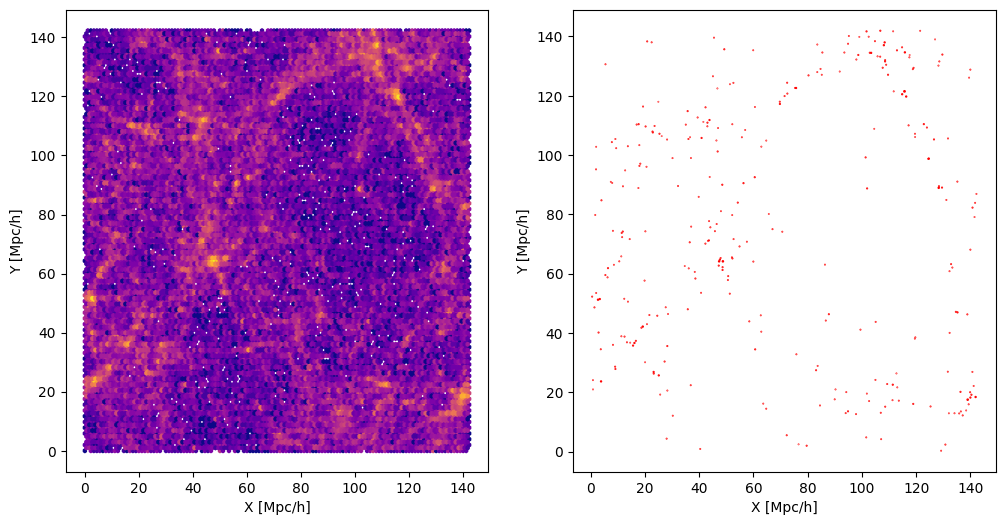

In [240]:
ipick=np.logical_and(snap.pos[:,2]<100,snap.pos[:,2]>0)
jpick=np.logical_and(halo.GroupPos[:,2]<100,halo.GroupPos[:,2]>0)

fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,2,1)
ax.set_xlabel("X [Mpc/h]")
ax.set_ylabel("Y [Mpc/h]")
ax.hexbin(snap.pos[ipick][:,0],snap.pos[ipick][:,1],bins='log',gridsize=128,cmap='plasma')

ax=fig.add_subplot(1,2,2)
ax.set_xlabel("X [Mpc/h]")
ax.set_ylabel("Y [Mpc/h]")
ax.scatter(halo.GroupPos[jpick][:,0],halo.GroupPos[jpick][:,1],s=halo.GroupR200[jpick]/np.max(halo.GroupR200[jpick]),color="red")

Text(0, 0.5, '$Log_{10}~dN/dLog_{10}M~[h^{-3} Mpc^3]$')

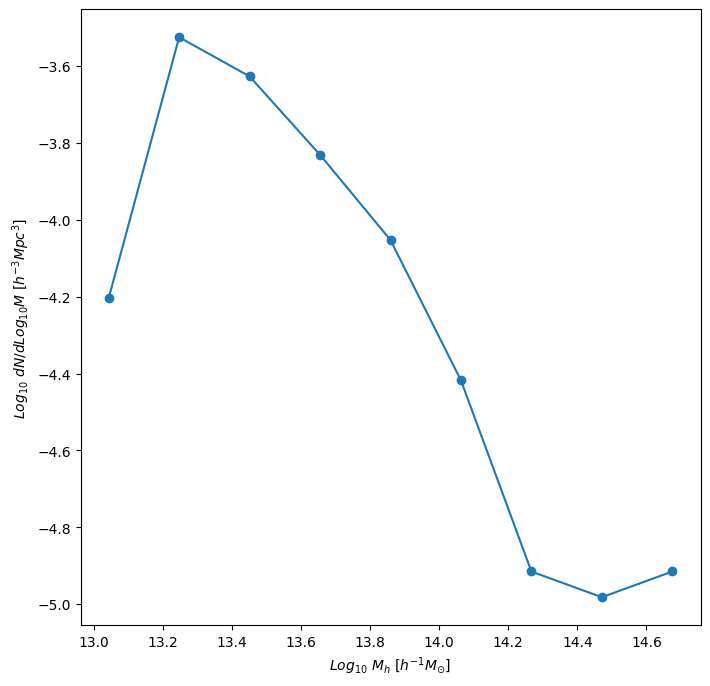

In [241]:
dlm=0.2
numbins=int((np.max(np.log10(halo.GroupMass))-np.min(np.log10(halo.GroupMass)))/dlm)
(num,lmbins)=np.histogram(np.log10(halo.GroupMass)+10,bins=numbins)
lm=np.array([])
for i in range(len(lmbins)-1):
    lm=np.append(lm,0.5*(lmbins[i]+lmbins[i+1]))
ldndlm=np.log10(num/snap.BoxSize**3/dlm)
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
ax.scatter(lm,ldndlm)
ax.plot(lm,ldndlm)
ax.set_xlabel(r'$Log_{10}~M_h~[h^{-1} M_{\odot}]$')
ax.set_ylabel(r'$Log_{10}~dN/dLog_{10}M~[h^{-3} Mpc^3]$')

Tracking merger histories for 0470 halos


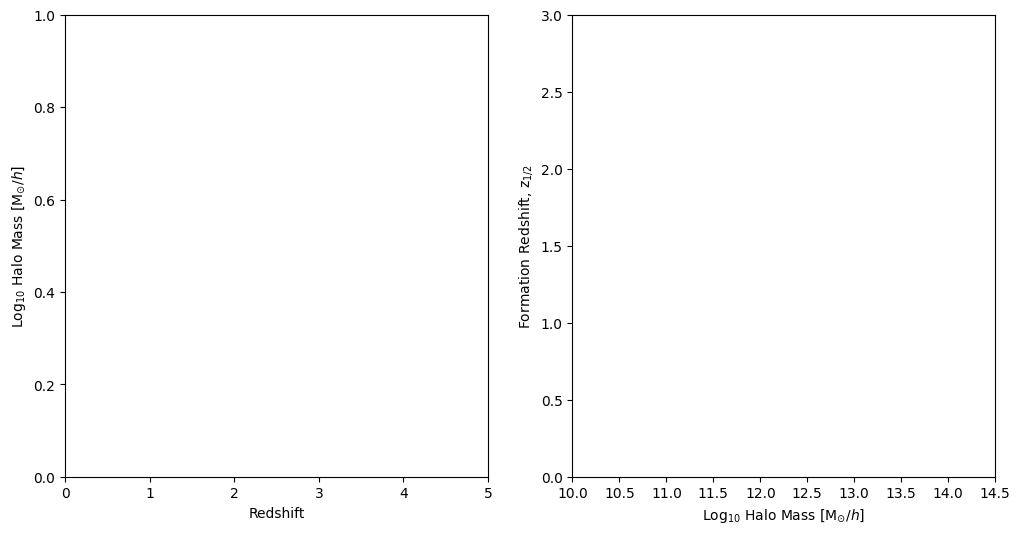

In [245]:
final_snap_num=31
halo_list=np.logical_and(halo.Structuretype==10,halo.GroupM200>0)
main_subhalo_list=halo.GroupID[halo_list]
print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,2,1)
plt.xlim([0,5])
plt.xlabel("Redshift")
plt.ylabel(r"Log$_{10}$ Halo Mass [M$_{\odot}/h$]")

formation_redshift=np.array([])
halo_mass=np.array([])
halo_m200=np.array([])

for main_subhalo_id in main_subhalo_list:
    redshift,mass,m200,subhalo_pos,subhalo_vel,\
    snapshot_number,group_number,subhalo_number,zform,\
    alpha,delta_m_overm=tree.TrackMainHaloProgenitor(main_subhalo_id,final_snap_num)
    if len(mass)>5:
        formation_redshift=np.append(formation_redshift,zform)
        halo_mass=np.append(halo_mass,mass[0])
        halo_m200=np.append(halo_m200,m200[0])        
        ax.plot(redshift,np.log10(m200)+10)    

ax=fig.add_subplot(1,2,2)
plt.ylim([0,3])
plt.xlim([10,14.5])
plt.ylabel(r"Formation Redshift, z$_{1/2}$")
plt.xlabel(r"Log$_{10}$ Halo Mass [M$_{\odot}/h$]")
ax.hexbin(np.log10(halo_m200)+10,formation_redshift,gridsize=128,bins='log')

In [243]:
# Use a KDTree to build a neighbour list
start_time=perf_counter()

kdtree=spatial.KDTree(snap.pos,compact_nodes=True, copy_data=False, balanced_tree=True,leafsize=10,boxsize=1.001*snap.BoxSize)

end_time=perf_counter()
print(f'It took {end_time-start_time:0.2f} seconds (s)')

It took 0.08 seconds (s)


In [244]:
start_time=perf_counter()

NumGroups=main_subhalo_list.size

print(f'Number of groups: {NumGroups: d}')

mass=np.zeros(NumGroups)
xcen=np.zeros(NumGroups)
ycen=np.zeros(NumGroups)
zcen=np.zeros(NumGroups)

ihalo=0

for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo.GroupID)[0]
    rhalo=halo.GroupR200[halo_id]
    # Centre of halo
    pos_halo=halo.GroupPos[halo_id]
    pids=kdtree.query_ball_point(pos_halo,r=rhalo)[0]#,return_sorted=True)#,return_length=True)    
    dr=snap.pos[pids]-halo.GroupPos[halo_id]
    dr[:,0]=np.where(dr[:,0]>0.5*snap.BoxSize,dr[:,0]-snap.BoxSize,dr[:,0])
    dr[:,0]=np.where(dr[:,0]<-0.5*snap.BoxSize,dr[:,0]+snap.BoxSize,dr[:,0])

    dr[:,1]=np.where(dr[:,1]>0.5*snap.BoxSize,dr[:,1]-snap.BoxSize,dr[:,1])
    dr[:,1]=np.where(dr[:,1]<-0.5*snap.BoxSize,dr[:,1]+snap.BoxSize,dr[:,1])
    
    dr[:,2]=np.where(dr[:,2]>0.5*snap.BoxSize,dr[:,2]-snap.BoxSize,dr[:,2])
    dr[:,2]=np.where(dr[:,2]<-0.5*snap.BoxSize,dr[:,2]+snap.BoxSize,dr[:,2])

    r=np.sqrt(dr[:,0]**2+dr[:,1]**2+dr[:,2]**2)

    indx=np.where(r<rhalo)[0]

    xc=np.sum(snap.pos[pids][indx][:,0])/snap.pos[pids][indx][:,0].size
    yc=np.sum(snap.pos[pids][indx][:,1])/snap.pos[pids][indx][:,1].size
    zc=np.sum(snap.pos[pids][indx][:,2])/snap.pos[pids][indx][:,2].size

    mass[ihalo]=halo.GroupM200[halo_id]
    xcen[ihalo]=xc
    ycen[ihalo]=yc
    zcen[ihalo]=zc
    ihalo+=1

end_time=perf_counter()
print(f'It took {end_time-start_time:0.2f} seconds (s)')    

Number of groups:  470
It took 0.04 seconds (s)


/var/folders/5j/77cr87r17bd1d4qg5mt7bc1hp4wxl1/T/ipykernel_51512/3770416952.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mass[ihalo]=halo.GroupM200[halo_id]
